## Description:

 Hypothesis testing of microbial community composition and relation to enzyme activity


# Setting variables

In [3]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/ordination/ord_raw/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [1]:

%load_ext rpy2.ipython

In [2]:
%%R

library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)
library(DESeq2)



/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Need help? Try the ggplot2 mailing list:
http://groups.google.com/group/ggplot2.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106

# Setting files

# Loading/editting OTU table

In [5]:
%%R 
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_relabund')
physeq.Full = readRDS(F)
physeq.Full.m = physeq.Full %>% sample_data
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 45 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


## Calculate pairwise weighted Unifrac distances between samples

In [8]:
%%R
physeq.thresh = physeq.Full

In [9]:
%%R
registerDoParallel(cores=28)
full.wunif.dist = phyloseq::distance(physeq.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [10]:
%%R
registerDoParallel(cores=28)
full.bray.dist = phyloseq::distance(physeq.thresh, 
                      method = "bray", 
                      parallel = TRUE, 
                      normalized = FALSE)

# NMDS of w-unif

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Saving 8.33 x 4.86 in image

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Run 0 stress 0.1405104 
Run 1 stress 0.1849687 
Run 2 stress 0.1667222 
Run 3 stress 0.152769 
Run 4 stress 0.1412398 
Run 5 stress 0.1759455 
Run 6 stress 0.1434255 
Run 7 stress 0.1837283 
Run 8 stress 0.1423363 
Run 9 stress 0.1641373 
Run 10 stress 0.1754267 
Run 11 stress 0.1800338 
Run 12 stress 0.1502802 
Run 13 stress 0.1709658 
Run 14 stress 0.143757 
Run 15 stress 0.1545498 
Run 16 stress 0.1444139 
Run 17 stress 0.1547933 
Run 18 stress 0.1769114 
Run 19 stress 0.1422501 
Run 20 stress 0.1419686 


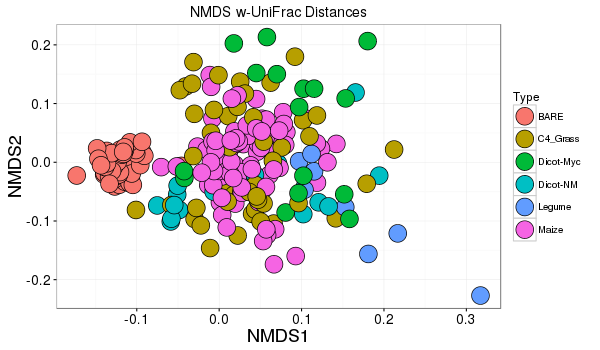

In [11]:
%%R -w 600 -h 350

nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = full.wunif.dist)

p = plot_ordination(physeq.thresh, nmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Type), pch = 21, size = 8) +
        theme_bw() +
        theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 18)) +
        labs(title = "NMDS w-UniFrac Distances", size = 20)
        #scale_size(range=c(2,8))

##need arrange into a presentation quality graphic and save

grid.arrange(p1, ncol=1)
ggsave(filename = "NMDS_full_wunif.pdf", plot = p1)

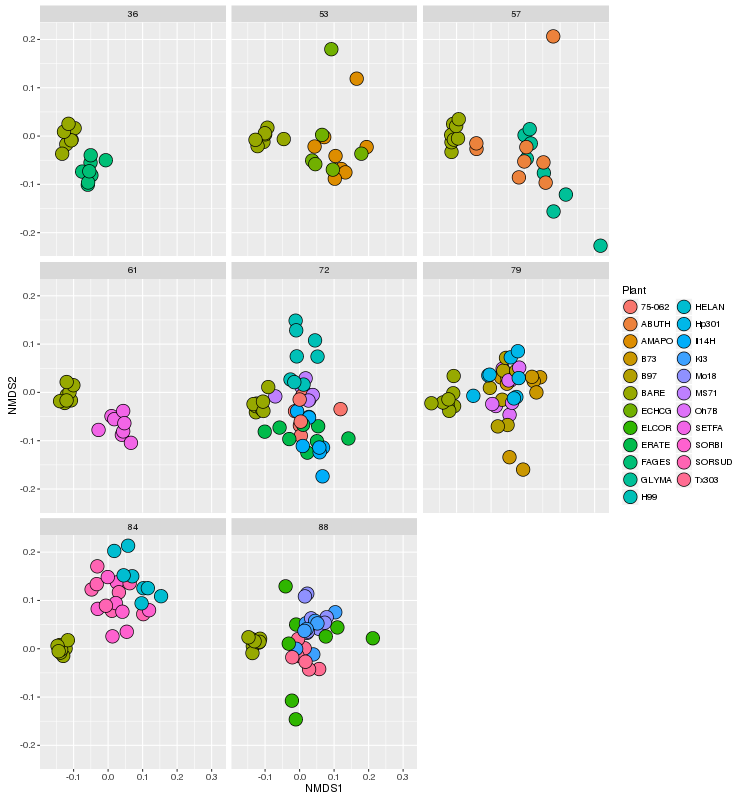

In [12]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) +
        facet_wrap(~ DAP) +
        scale_size(range=c(2,8))

p1

## Subset just plants to evaluate variation without bare soil

In [13]:
%%R

physeq.plant = subset_samples(physeq.thresh, Plant != "BARE")
physeq.plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 45 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [14]:
%%R
#create maize/non-maize variable
sample_data(physeq.plant)$Maize = ifelse(sample_data(physeq.plant)$Type == "Maize", "Maize", 
                                         "Annuals")
sample_data(physeq.plant)$Maize = factor(sample_data(physeq.plant)$Maize)

In [15]:
%%R
registerDoParallel(cores=28)
plant.wunif.dist = phyloseq::distance(physeq.plant, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [16]:
%%R
registerDoParallel(cores=28)
plant.bray.dist = phyloseq::distance(physeq.plant, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

# NMDS of plant only w-UNIF

In [17]:
%%R -w 800 -h 350


nmds = ordinate(physeq.plant, 
                method = "NMDS", 
               distance = plant.wunif.dist)

p = plot_ordination(physeq.plant, nmds, justDF = TRUE)
str(p)

Run 0 stress 0.1707799 
Run 1 stress 0.2034354 
Run 2 stress 0.2013083 
Run 3 stress 0.1844614 
Run 4 stress 0.2038275 
Run 5 stress 0.1856016 
Run 6 stress 0.1833893 
Run 7 stress 0.2074355 
Run 8 stress 0.1900693 
Run 9 stress 0.1786426 
Run 10 stress 0.2047676 
Run 11 stress 0.1976946 
Run 12 stress 0.1868399 
Run 13 stress 0.1712287 
... procrustes: rmse 0.0247601  max resid 0.2539074 
Run 14 stress 0.1849638 
Run 15 stress 0.1707785 
... New best solution
... procrustes: rmse 0.0002542276  max resid 0.002986529 
*** Solution reached
'data.frame':	174 obs. of  48 variables:
 $ NMDS1              : num  -0.06116 -0.02527 -0.07499 -0.00363 -0.01336 ...
 $ NMDS2              : num  -0.0474 -0.0252 -0.0436 -0.0214 -0.012 ...
 $ X.sample           : chr  "sample5-1.22_Nneg" "sample6-4.12_Npos" "sample4-1.03_Npos" "sample5-2.06_Npos" ...
 $ Library            : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Primer_Plate       : int  1 2 1 2 2 1 1 1 1 2 ...
 $ Primer_Well_ID     : Factor w/ 93 levels "A

In [18]:
%%R
#keepvariables = sample_data(physeq.plant)[,c(34:37,43)]
plantsd = data.frame(sample_data(physeq.plant))
colnames(plantsd)

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Planted"             "Biomass_P"           "SLA"                
[25] "Leaf_N"              "Leaf_C"              "LeafC_N"            
[28] "LNa"                 "Plant_N"             "Plant_C"            
[31] "Plant_CN"            "d15N"                "tN_p"               
[34] "BX_rel"              "CB_rel"              "LAP_rel"            
[37] "NAG_rel"             "NO3_ug_g"            "NH4_ug_g"           
[40] "InorganicN"          "Resid_logB"          "Resid_logN"         
[43] "

## Now overlay enzyme data

In [21]:
%%R
#keepvariables = sample_data(physeq.plant)[,c(34:37,43)]
plantsd = data.frame(sample_data(physeq.plant))
print(colnames(plantsd))
plantenz = plantsd[,34:37] #select enzyme activity data

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Planted"             "Biomass_P"           "SLA"                
[25] "Leaf_N"              "Leaf_C"              "LeafC_N"            
[28] "LNa"                 "Plant_N"             "Plant_C"            
[31] "Plant_CN"            "d15N"                "tN_p"               
[34] "BX_rel"              "CB_rel"              "LAP_rel"            
[37] "NAG_rel"             "NO3_ug_g"            "NH4_ug_g"           
[40] "InorganicN"          "Resid_logB"          "Resid_logN"         
[43] "

In [22]:
%%R
cor(plantenz)


           BX_rel    CB_rel   LAP_rel   NAG_rel
BX_rel  1.0000000 0.8802143 0.5549035 0.3662651
CB_rel  0.8802143 1.0000000 0.4529430 0.4425274
LAP_rel 0.5549035 0.4529430 1.0000000 0.0733075
NAG_rel 0.3662651 0.4425274 0.0733075 1.0000000



***VECTORS

           NMDS1    NMDS2     r2 Pr(>r)   
BX_rel  -0.17221  0.98506 0.0639  0.005 **
CB_rel  -0.05205  0.99864 0.0323  0.063 . 
LAP_rel  0.99969 -0.02491 0.0070  0.546   
NAG_rel -0.13051  0.99145 0.0459  0.022 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Permutation: free
Number of permutations: 999


               NMDS1        NMDS2 var
BX_rel  -0.043539242  0.249052608  BX
CB_rel  -0.009353241  0.179463987  CB
LAP_rel  0.083910429 -0.002090552 LAP
NAG_rel -0.027947392  0.212316178 NAG


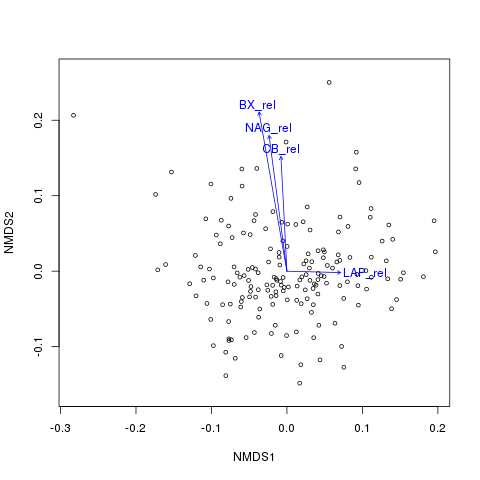

In [24]:
%%R
#ord.fit = envfit(nmds ~ BX_activity_g + CB_activity_g + LAP_activity_g + NAG_activity_g, plantsd)
ord.fit = envfit(nmds ~ BX_rel + CB_rel + LAP_rel + NAG_rel, plantenz)
sol = nmds
NMDS = data.frame(MDS1 = sol$points[,1], MDS2 = sol$points[,2])
#plot(nmds)
#plot(ord.fit)
ord.fit %>% print
enz_scores = data.frame(scores(ord.fit, "vectors")) 
enz_scores$var = c("BX", "CB", "LAP", "NAG")
enz_scores %>% print
plot(nmds)
plot(ord.fit)

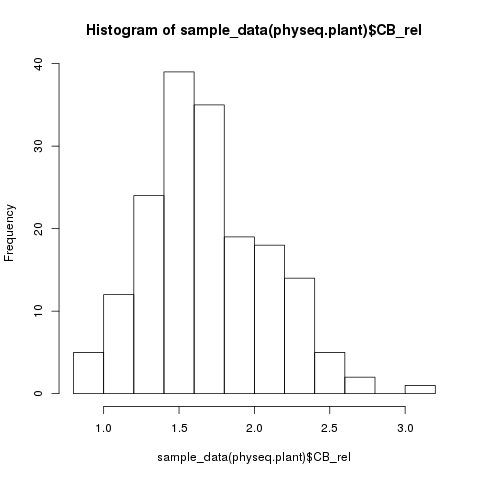

In [25]:
%%R
hist(sample_data(physeq.plant)$CB_rel)


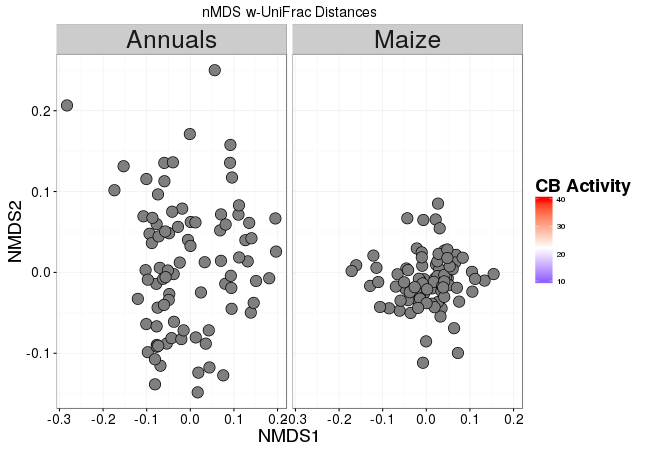

In [27]:
%%R -w 650 -h 450


# generating plot with enzyme activity of LAP as coloring 
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(color=LAP_dif), size = 7, pch=21)+
        geom_point(size = 5, pch = 21, aes(fill = CB_rel)) +
        scale_fill_gradient2(name = "CB Activity", limits=c(10,40), low = "blue", high = "red", midpoint = 22) + 
    #geom_segment(data=enz_scores,aes(x=0,xend=NMDS1,y=0,yend=NMDS2),
     # arrow = arrow(length = unit(0.5, "cm")),colour="grey",inherit_aes=FALSE)+
        #geom_text(data=enz_scores,aes(x=NMDS1,y=NMDS2,label=var),size=5) +
        facet_wrap(~Maize) +
        theme_bw() +
        theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 18),
             strip.text = element_text(size=25)) +
        theme(legend.title = element_text(colour = 'black', angle = 0, size = 18, 
                                          hjust = 3, vjust = 7, face = 'bold')) +
        theme(legend.text = element_text(size = 8)) +
        #theme(legend.key.size = unit(1, "cm"))+
        labs(title = "nMDS w-UniFrac Distances", size = 20)

p1
#ggsave(filename = "facet_NMDS_w-enz.pdf", plot = p1)

# Beta-diversity hypothesis testing on plant subset 
*Note that maize/non-maize variable should be tested too, for consistency

In [49]:
%%R
colnames(df)

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Biomass_P"           "SLA"                 "Leaf_N"             
[25] "LeafC_N"             "LNa"                 "Plant_N"            
[28] "Plant_C"             "Plant_CN"            "d15N"               
[31] "tN_p"                "BX_activity_g"       "CB_activity_g"      
[34] "LAP_activity_g"      "NAG_activity_g"      "BX_dif"             
[37] "CB_dif"              "LAP_dif"             "NAG_dif"            
[40] "BX_rel"              "CB_rel"              "LAP_rel"            
[43] "

In [51]:
%%R
df = as(sample_data(physeq.plant), "data.frame")
d = plant.wunif.dist
plantadonis = adonis(d ~ tN_p + DAP + Plant + Treatment + Rep, df)
plantadonis


Call:
adonis(formula = d ~ tN_p + DAP + Plant + Treatment + Rep, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
tN_p        1    0.4263 0.42627  31.907 0.09773  0.001 ***
DAP         1    0.2117 0.21170  15.846 0.04854  0.001 ***
Plant      20    1.6049 0.08024   6.006 0.36796  0.001 ***
Treatment   1    0.0420 0.04198   3.142 0.00962  0.004 ** 
Rep         1    0.0593 0.05933   4.441 0.01360  0.001 ***
Residuals 151    2.0173 0.01336         0.46254           
Total     175    4.3615                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [52]:
%%R
#Compare bray to w-unifrac
df = as(sample_data(physeq.plant), "data.frame")
d = plant.bray.dist
plantadonis = adonis(d ~ DAP + Plant + Treatment, df)
plantadonis


Call:
adonis(formula = d ~ DAP + Plant + Treatment, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
DAP         1    1.3220 1.32197 15.7127 0.06115  0.001 ***
Plant      20    7.1939 0.35970  4.2753 0.33276  0.001 ***
Treatment   1    0.2303 0.23031  2.7374 0.01065  0.001 ***
Residuals 153   12.8725 0.08413         0.59543           
Total     175   21.6187                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


*Note: what OTUs are influenced by fertilization treatment?

In [124]:
%%R
plant_group = get_variable(physeq.plant, "Plant")
d = plant.wunif.dist
ano1 = anosim(d, plant_group)
summary(ano1)


Call:
anosim(dat = d, grouping = plant_group) 
Dissimilarity: 

ANOSIM statistic R: 0.5934 
      Significance: 0.001 

Permutation: free
Number of permutations: 999

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0229 0.0295 0.0347 0.0431 

Dissimilarity ranks between and within classes:
         0%     25%    50%      75%  100%     N
Between   1 4134.75 7936.5 11670.25 15400 14784
75-062   42  378.50  999.0  3114.50  8061    28
ABUTH    70 2466.50 6506.0 13033.50 15131    28
AMAPO    17  927.25 2764.5  5019.25 13047    28
B73     104  901.00 3708.5  9620.75 12105    28
B97      31  925.50 1528.0  4483.00  8971    28
ECHCG    22 4923.00 8179.0 12673.75 14619    28
ELCOR    38  376.25 1539.5  3906.00 10158    28
ERATE    20  723.00 2102.5  5215.25 14227    28
FAGES     2   15.50   79.0   321.25  2160    28
GLYMA   510 4319.00 8780.5 11514.50 15068    28
H99      72 1217.25 2842.5  4501.75  6104    28
HELAN    81 1004.00 1681.5  2865.75  8332    28
Hp301  

### Beta-diversity hypothesis tests on just maize

## Now on just non-maize Need to fix

In [101]:
%%R
sample_data(physeq.plant)$Maize

  [1] Maize   Maize   Annuals Maize   Maize   Maize   Annuals Annuals Annuals
 [10] Maize   Maize   Maize   Annuals Maize   Maize   Maize   Annuals Maize  
 [19] Maize   Annuals Maize   Maize   Maize   Annuals Maize   Maize   Annuals
 [28] Maize   Annuals Maize   Maize   Maize   Annuals Maize   Maize   Maize  
 [37] Maize   Maize   Maize   Annuals Maize   Maize   Maize   Annuals Annuals
 [46] Maize   Maize   Maize   Maize   Maize   Maize   Annuals Annuals Annuals
 [55] Maize   Annuals Maize   Annuals Maize   Maize   Maize   Annuals Maize  
 [64] Maize   Annuals Annuals Annuals Maize   Maize   Maize   Maize   Annuals
 [73] Maize   Maize   Maize   Annuals Annuals Maize   Annuals Annuals Annuals
 [82] Annuals Maize   Maize   Annuals Annuals Annuals Annuals Annuals Maize  
 [91] Annuals Annuals Annuals Annuals Maize   Annuals Annuals Annuals Annuals
[100] Annuals Annuals Annuals Maize   Annuals Annuals Maize   Annuals Annuals
[109] Maize   Maize   Annuals Annuals Annuals Maize   Annuals Ma

In [106]:
%%R
plant.nm = subset_samples(physeq.plant, Maize == "Annuals")
plant.m = subset_samples(physeq.plant, Maize == "Maize")
plant.nm
plant.m

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10493 taxa and 88 samples ]
sample_data() Sample Data:       [ 88 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 10493 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 10493 tips and 10492 internal nodes ]


In [108]:
%%R
registerDoParallel(cores=28)

maize.wunif.dist = phyloseq::distance(plant.m, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

nm.wunif.dist = phyloseq::distance(plant.nm, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

# Test correlation between enzyme activity and microbial community composition

In [28]:
%%R
colnames(Sd)


Error in colnames(Sd) : 
  error in evaluating the argument 'x' in selecting a method for function 'colnames': Error: object 'Sd' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in colnames(Sd) : 
  error in evaluating the argument 'x' in selecting a method for function 'colnames': Error: object 'Sd' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = full.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.04131 
      Significance: 0.083 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0389 0.0470 0.0550 0.0660 
Permutation: free
Number of permutations: 999



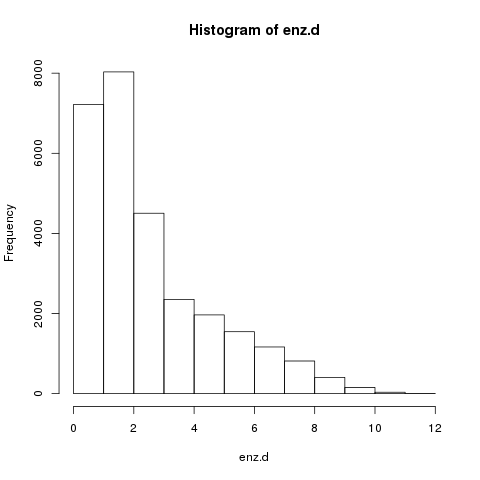

In [29]:
%%R
#Test on soil activity/rhizosphere effect
Sd = sample_data(physeq.thresh)
enz.d = dist(Sd[,32:35], method = "euclidian")
hist(enz.d)
M1 = mantel(full.wunif.dist, enz.d, method="pearson", permutations=999)
M1
#Model is not significant within just plants or within entire dataset


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = plant.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.005635 
      Significance: 0.413 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0503 0.0649 0.0860 0.1064 
Permutation: free
Number of permutations: 999



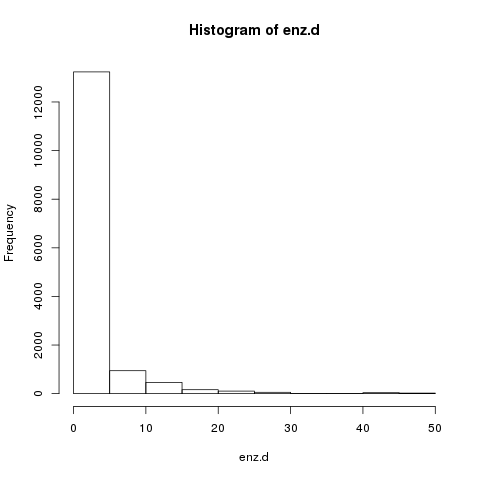

In [30]:
%%R
#Test on "difference" rhizosphere effect
Sd = sample_data(physeq.plant)
enz.d = dist(Sd[,36:39], method = "euclidean")
hist(enz.d)
M1 = mantel(plant.wunif.dist, enz.d, method="pearson", permutations=999)
M1
#Model is not significant based on difference calculation

$breaks
 [1]  0  5 10 15 20 25 30 35 40 45 50 55

$counts
 [1] 13312   801   397   279    92    82    12     9    11    46    10

$density
 [1] 0.1768919009 0.0106438110 0.0052753970 0.0037073949 0.0012225101
 [6] 0.0010896286 0.0001594578 0.0001195934 0.0001461697 0.0006112551
[11] 0.0001328815

$mids
 [1]  2.5  7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 47.5 52.5

$xname
[1] "enz.d"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = plant.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.02151 
      Significance: 0.283 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0533 0.0778 0.0936 0.1207 
Permutation: free
Number of permutations: 999



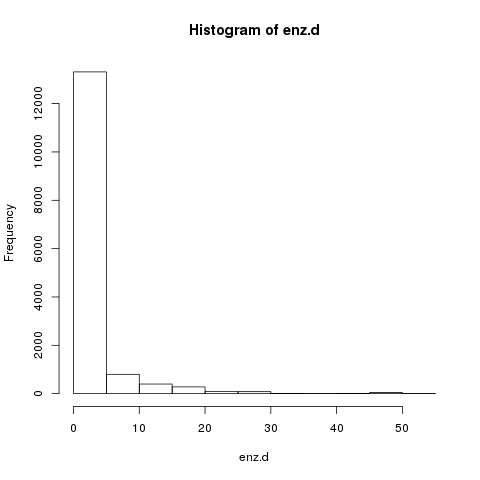

In [31]:
%%R
#Test on relative rhizosphere effect
Sd = sample_data(physeq.plant)
enz.d = dist(Sd[,40:43], method = "euclidian")
print(hist(enz.d))
M1 = mantel(plant.wunif.dist, enz.d, method="pearson", permutations=999)
print(M1)



In [32]:
%%R
#Test if rel effect is different when comparing among maize or non-maize
Sd = sample_data(plant.m)
enz.d = dist(Sd[,40:43], method = "euclidian")
print(hist(enz.d))
M1 = mantel(maize.wunif.dist, enz.d, method="pearson", permutations=999)
print(M1)

Sd = sample_data(plant.nm)
enz.d = dist(Sd[,40:43], method = "euclidian")
print(hist(enz.d))
M1 = mantel(nm.wunif.dist, enz.d, method="pearson", permutations=999)
print(M1)


Error in sample_data(plant.m) : 
  error in evaluating the argument 'object' in selecting a method for function 'sample_data': Error: object 'plant.m' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In as.matrix.data.frame(x) :
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  Setting class(x) to NULL;   result will no longer be an S4 object

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 3: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in sample_data(plant.m) : 
  error in evalu

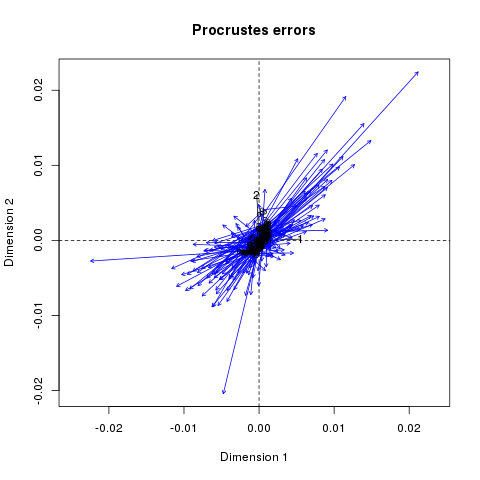

In [96]:
%%R
 p1 = protest(plant.wunif.dist, enz.d, scores = "sites", permutations = 999)
plot(p1)